In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logictensornetworks as ltn
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [2]:
df = pd.read_csv("/Users/eduard.hogea/Documents/Facultate/Internship/explorare/KNN99---LTN/datesets/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", skipinitialspace = True)



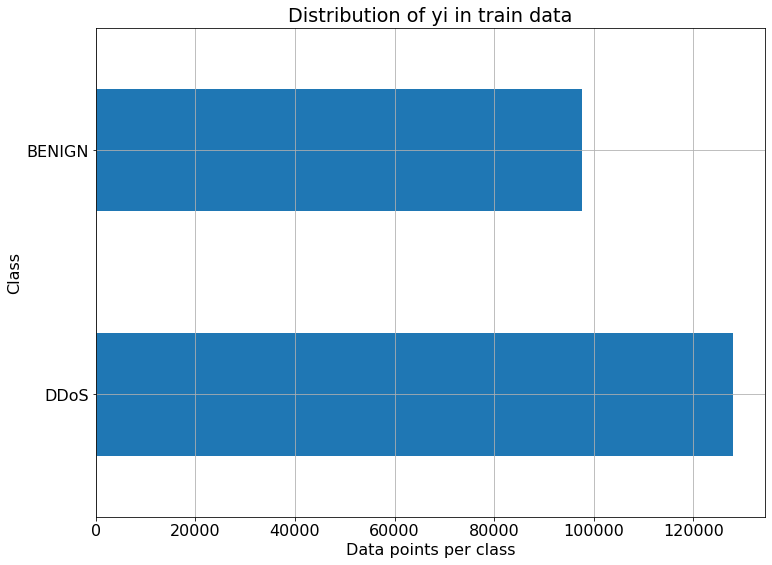

In [3]:
plt.figure(figsize=(12,9))
plt.rcParams.update({'font.size': 16})
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='barh')
plt.xlabel('Data points per class')
plt.ylabel('Class')
plt.title('Distribution of yi in train data')
plt.grid()
#plt.xlim([0, 100])
plt.show()

In [4]:
df = df.replace(['DDoS'],0)
df = df.replace(['BENIGN'],1)

In [5]:
df.drop_duplicates(keep= 'first', inplace=True) #eliminarea dublurilor liniilor
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
print('Null values in dataset are',len(df[df.isnull().any(1)]))
df.shape

Null values in dataset are 0


(223082, 79)

 # Data normalization

In [6]:
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
# # selecting numeric attributes columns from data
# numeric_col = df.select_dtypes(include='number').columns

In [7]:
# # using standard scaler for normalizing
# std_scaler = StandardScaler()
# def normalization(df,col):
#     for i in col:
#         arr = df[i]
#         arr = np.array(arr)
#         df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
#     return df

In [8]:
# # calling the normalization() function
# df = normalization(df.copy(),numeric_col)

# Data to tensor

In [9]:
column_array = []
for c in df.columns: 
    column_array.append(c)

In [10]:
df.shape
df = df.sample(frac=1)

In [11]:
df.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
158912,80,4242279,5,0,30,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
118866,80,10012745,4,0,24,0,6,6,6.000000,0.000000,...,20,1005.0,0.0,1005,1005,10000000.0,0.0,10000000,10000000,0
27259,80,1586638,3,5,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
124701,80,89895790,8,4,56,11607,20,0,7.000000,5.656854,...,20,1016.0,0.0,1016,1016,44500000.0,51400000.0,80800000,8094799,0
126843,80,1001630,2,6,20,11601,20,0,10.000000,14.142136,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4698,53,85169,1,1,56,122,56,56,56.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,1
113642,80,6930834,4,0,24,0,6,6,6.000000,0.000000,...,20,25112.0,0.0,25112,25112,6905722.0,0.0,6905722,6905722,0
111691,65295,23111096,1,6,6,36,6,6,6.000000,0.000000,...,20,27506.0,0.0,27506,27506,23100000.0,0.0,23100000,23100000,1
107308,80,83924288,8,5,56,11607,20,0,7.000000,5.656854,...,20,1006.0,0.0,1006,1006,41400000.0,44700000.0,73100000,9823595,0
100754,80,24067,3,4,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [12]:
features = df[column_array]
features.drop('Label', inplace = True, axis = 1)
label_label=df['Label']
#batch_size= 100
batch_size = 20000
ds_train = tf.data.Dataset.from_tensor_slices((features[:190000],label_label[:190000])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((features[190000:],label_label[190000:])).batch(batch_size)

Metal device set to: Apple M1


2022-05-07 20:47:21.157711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-07 20:47:21.157796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Creare model

In [13]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(16,16,8)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="elu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

logits_model = MLP(3)
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

In [14]:
class_DDoS = ltn.Constant(0, trainable=False)
class_BENIGN = ltn.Constant(1, trainable=False)

In [15]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=1),semantics="forall")

In [16]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=1))

@tf.function
def axioms(features, labels, training=False):
    x_DDoS = ltn.Variable("x_DDoS",features[labels==0])
    x_BENIGN = ltn.Variable("x_BENIGN",features[labels==1])
    axioms = [
        Forall(x_DDoS,p([x_DDoS,class_DDoS],training=training)),
        Forall(x_BENIGN,p([x_BENIGN,class_BENIGN],training=training)),
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [17]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

2022-05-07 20:47:22.097712: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-07 20:47:22.097799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Initial sat level 0.07630


In [18]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,2),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,2),predictions)

In [20]:
from collections import defaultdict

def train(
        epochs,
        metrics_dict, 
        ds_train, 
        ds_test, 
        train_step, 
        test_step,
        track_metrics=1,
        csv_path=None,
        scheduled_parameters=defaultdict(lambda : {})
    ):
    """
    Args:
        epochs: int, number of training epochs.
        metrics_dict: dict, {"metrics_label": tf.keras.metrics instance}.
        ds_train: iterable dataset, e.g. using tf.data.Dataset.
        ds_test: iterable dataset, e.g. using tf.data.Dataset.
        train_step: callable function. the arguments passed to the function
            are the itered elements of ds_train.
        test_step: callable function. the arguments passed to the function
            are the itered elements of ds_test.
        csv_path: (optional) path to create a csv file, to save the metrics.
        scheduled_parameters: (optional) a dictionary that returns kwargs for
            the train_step and test_step functions, for each epoch.
            Call using scheduled_parameters[epoch].
    """
    template = "Epoch {}"
    for metrics_label in metrics_dict.keys():
        template += ", %s: {:.4f}" % metrics_label
    if csv_path is not None:
        csv_file = open(csv_path,"w+")
        headers = ",".join(["Epoch"]+list(metrics_dict.keys()))
        csv_template = ",".join(["{}" for _ in range(len(metrics_dict)+1)])
        csv_file.write(headers+"\n")
    
    for epoch in range(epochs):
        for metrics in metrics_dict.values():
            metrics.reset_states()

        for batch_elements in ds_train:
            train_step(*batch_elements,**scheduled_parameters[epoch])
        for batch_elements in ds_test:
            test_step(*batch_elements,**scheduled_parameters[epoch])

        metrics_results = [metrics.result() for metrics in metrics_dict.values()]
        if epoch%track_metrics == 0:
            print(template.format(epoch,*metrics_results))
        if csv_path is not None:
            csv_file.write(csv_template.format(epoch,*metrics_results)+"\n")
            csv_file.flush()
    if csv_path is not None:
        csv_file.close()

In [21]:
EPOCHS = 300
train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="results5.csv",
    track_metrics=1
)

2022-05-07 20:47:22.725083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-07 20:47:25.133552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-07 20:47:25.702239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-07 20:47:25.963933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 0, train_sat_kb: 0.1066, test_sat_kb: 0.1425, train_accuracy: 0.0998, test_accuracy: 0.1293
Epoch 1, train_sat_kb: 0.1299, test_sat_kb: 0.1247, train_accuracy: 0.1149, test_accuracy: 0.1064
Epoch 2, train_sat_kb: 0.1255, test_sat_kb: 0.1269, train_accuracy: 0.1075, test_accuracy: 0.1077
Epoch 3, train_sat_kb: 0.1294, test_sat_kb: 0.1305, train_accuracy: 0.1107, test_accuracy: 0.1108
Epoch 4, train_sat_kb: 0.1325, test_sat_kb: 0.1336, train_accuracy: 0.1134, test_accuracy: 0.1137
Epoch 5, train_sat_kb: 0.1362, test_sat_kb: 0.1382, train_accuracy: 0.1167, test_accuracy: 0.1177
Epoch 6, train_sat_kb: 0.1702, test_sat_kb: 0.2113, train_accuracy: 0.1514, test_accuracy: 0.1992
Epoch 7, train_sat_kb: 0.2973, test_sat_kb: 0.3767, train_accuracy: 0.2916, test_accuracy: 0.3833
Epoch 8, train_sat_kb: 0.4006, test_sat_kb: 0.4116, train_accuracy: 0.4017, test_accuracy: 0.4126
Epoch 9, train_sat_kb: 0.4249, test_sat_kb: 0.4329, train_accuracy: 0.4224, test_accuracy: 0.4302
Epoch 10, train_sat_

Text(27.125, 0.5, 'Satisfaction level')

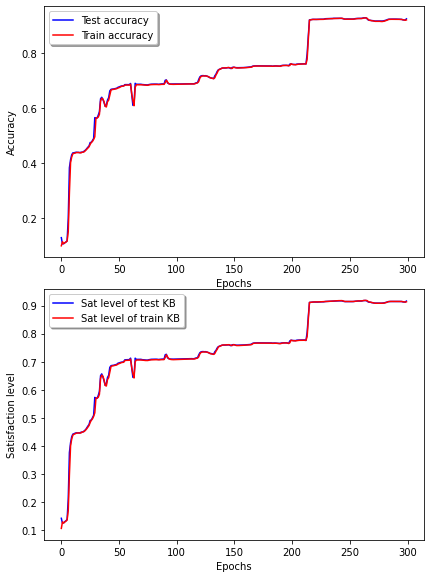

<Figure size 1500x900 with 0 Axes>

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 8

results = pd.read_csv("results5.csv", skipinitialspace = True)
fig, ax = plt.subplots(2,1)
fig.tight_layout()
figure(figsize=(10, 6), dpi=150)
ax[0].plot(results['test_accuracy'], color='b', label="Test accuracy")
ax[0].plot(results['train_accuracy'], color='r', label="Train accuracy",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(results['test_sat_kb'], color='b', label="Sat level of test KB")
ax[1].plot(results['train_sat_kb'], color='r',label="Sat level of train KB")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Satisfaction level')